## TOC:
   1. [Load the Modules](#first-bullet)
   2. [Load, Examine and Explore the Data](#second-bullet)
   3. [Plotting some Example](#second1-bullet)
   4. [Creating model](#4-bullet)
   5. [Training the model](#5-bullet)
   6. [Visualizing Loss and Accuracy](#6-bullet)
   7. [Predictings Image](#7-bullet)

# 1. Load the Modules <a class="anchor" id="first-bullet"></a>

In [1]:
import os
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 2. Load the Data, Examine and Explore <a class="anchor" id="second-bullet"></a>

In [2]:
batch_size = 32
img_height = 180
img_width = 180

In [3]:
data_dir = pathlib.Path('/datasets/utk-face/')
image_count = len(list(data_dir.glob('*.jpg')))
print(image_count)

23705


In [4]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*.jpg'))
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [5]:
true_label = {
    0: 'White',
    1: 'Black',
    2: 'Asian',
    3: 'Indian',
    4: 'Latin',
}

In [6]:
val_size = int(image_count * 0.15)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

20150
3555


In [7]:
# Functions to load and process images

def get_label(file_path):
    file = tf.strings.split(file_path, os.path.sep)[-1]
    label = tf.strings.split(file, '_')[2]
    label = tf.strings.to_number(label, tf.int32)
    return label

def read_n_decode_img(file_path):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
    label = get_label(file_path)
    img = read_n_decode_img(file_path)
    return img, label

def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

In [8]:
print(type(train_ds))
print(type(val_ds))

<class 'tensorflow.python.data.ops.dataset_ops.SkipDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TakeDataset'>


In [9]:
train_ds = train_ds.map(
    process_path,
    num_parallel_calls=tf.data.AUTOTUNE
)
val_ds = val_ds.map(
    process_path,
    num_parallel_calls=tf.data.AUTOTUNE
)

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

# 3. Plotting some Examples <a class="anchor" id="second1-bullet"></a>

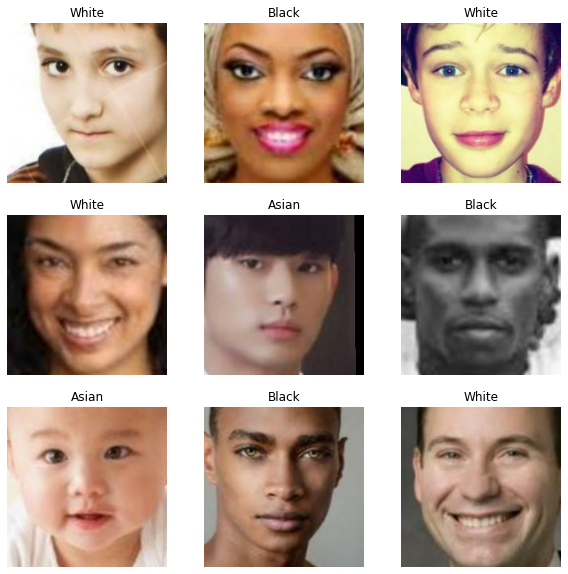

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(true_label[labels[i].numpy()])
        plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


# 4. Creating model <a class="anchor" id="4-bullet"></a>
Here we're using Convolutional Neural Network (CNN)

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# 5. Training the model <a class="anchor" id="5-bullet"></a>

In [14]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=2
)

Epoch 1/2
630/630 [==============================] - 175s 255ms/step - loss: 2.2722 - accuracy: 0.4947 - val_loss: 1.1086 - val_accuracy: 0.5975
Epoch 2/2
630/630 [==============================] - 153s 232ms/step - loss: 0.9875 - accuracy: 0.6466 - val_loss: 1.1451 - val_accuracy: 0.5899


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 178, 178, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 89, 89, 64)        0         
                                                                 
 flatten (Flatten)           (None, 506944)            0

# 6. Visualizing Loss and Accuracy <a class="anchor" id="6-bullet"></a>

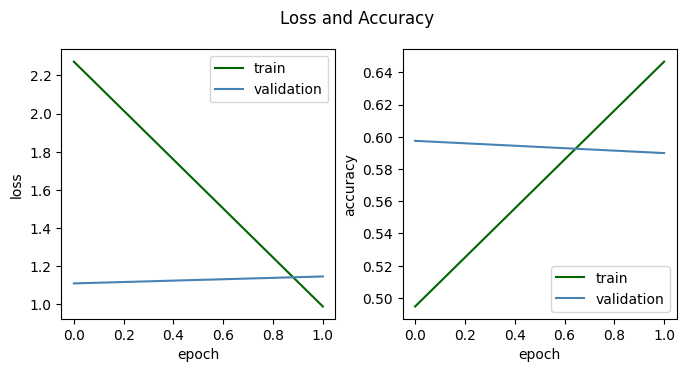

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=100)
fig.suptitle('Loss and Accuracy')
fig.tight_layout()
fig.set_size_inches(7, 3.5, forward=True)

ax1.plot(history.history['loss'], color="darkgreen")
ax1.plot(history.history['val_loss'], color="steelblue")
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend(['train', 'validation'], loc='upper right')

ax2.plot(history.history['accuracy'], color="darkgreen")
ax2.plot(history.history['val_accuracy'], color="steelblue")
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend(['train', 'validation'], loc='lower right')

# 7. Predicting Images <a class="anchor" id="7-bullet"></a>

In [ ]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(3, 3, 1)
ax1.imshow(images[i].numpy().astype("uint8"))
ax1.title(true_label[labels[i].numpy()])
ax1.axis("off")
ax2 = plt.subplot(3, 3, 2)
ax2.set_ylim(0, 1)
ax2.bar(x, y, color=('#8093f1'))
plt.show()

# Conclusión
* As can be seen, around epoch 18, the model begins to stop learning and possibly begins to overfit, this can be treated by making improvements to the model design.

* Another interesting aspect that can be dealt with is the complexity in the prediction of children's faces, which, as can be seen, neither of the two classes has a clear advantage over the other.

In [28]:
# # serialize model to JSON
# model_json = model.to_json()
# with open("model/gener-detection/model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("model.h5")
# print("Saved model to disk")

Saved model to disk
